In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the dataset
data = pd.read_csv('train.csv')
data

,VWTI,SWTI,CWTI,EI,Class
0,2.263400,-4.4862,3.65580,-0.612510,0
1,3.271800,1.7837,2.11610,0.613340,0
2,-3.941100,-12.8792,13.05970,-3.312500,1
3,0.519500,-3.2633,3.08950,-0.984900,0
4,2.569800,-4.4076,5.98560,0.078002,0
...,...,...,...,...,...
1091,1.640600,3.5488,1.39640,-0.364240,0
1092,-0.048008,-1.6037,8.47560,0.755580,0
1093,2.942100,7.4101,-0.97709,-0.884060,0
1094,1.964700,6.9383,0.57722,0.663770,0


In [3]:
# Separate features and target
X = data[['VWTI', 'SWTI', 'CWTI', 'EI']]  # Adjust these columns to your dataset
y = data['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Ensure target is in binary format (0 or 1 for binary classification)
# No need for one-hot encoding in binary classification
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (700, 4), y_train shape: (700,)
X_val shape: (176, 4), y_val shape: (176,)
X_test shape: (220, 4), y_test shape: (220,)


In [4]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Dropout to reduce overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),  # Another Dropout layer
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=5,          # Stops training after 5 epochs with no improvement
    restore_best_weights=True  # Restores the best model weights
)

# Check model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (

In [5]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]  # Use early stopping callback
)

Epoch 1/15


22/22 [==============================] - 3s 22ms/step - loss: 0.6437 - accuracy: 0.7086 - val_loss: 0.5373 - val_accuracy: 0.8750
Epoch 2/15
22/22 [==============================] - 0s 8ms/step - loss: 0.4860 - accuracy: 0.8771 - val_loss: 0.3832 - val_accuracy: 0.8977
Epoch 3/15
22/22 [==============================] - 0s 8ms/step - loss: 0.3443 - accuracy: 0.9143 - val_loss: 0.2526 - val_accuracy: 0.9205
Epoch 4/15
22/22 [==============================] - 0s 9ms/step - loss: 0.2194 - accuracy: 0.9357 - val_loss: 0.1633 - val_accuracy: 0.9375
Epoch 5/15
22/22 [==============================] - 0s 10ms/step - loss: 0.1493 - accuracy: 0.9543 - val_loss: 0.1094 - val_accuracy: 0.9602
Epoch 6/15
22/22 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.9671 - val_loss: 0.0803 - val_accuracy: 0.9659
Epoch 7/15
22/22 [==============================] - 0s 10ms/step - loss: 0.0787 - accuracy: 0.9786 - val_loss: 0.0642 - val_accuracy: 0.9659
Epoch 8/15
22/

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

7/7 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 1.0000
Test Loss: 0.0090, Test Accuracy: 1.0000


In [7]:
# You can also generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)


print("Classification Report:")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00        85

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220



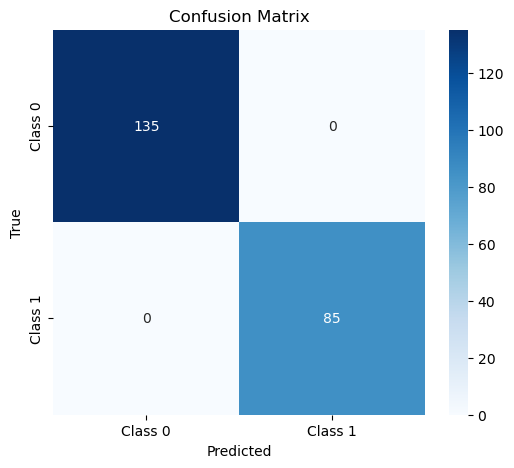

In [8]:
# Plot confusion matrix using seaborn heatmap
import seaborn as sns
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
import numpy as np


# Define the make_prediction function
def make_prediction(input_data):
    # Preprocess input data (apply scaling)
    # Use the pre-loaded scaler instead of creating a new one
    input_data_scaled = scaler.transform(input_data)  # Use transform instead of fit_transform
    
    # Use the trained model to predict the class
    predictions = model.predict(input_data_scaled)
    
    # Convert prediction to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Return the prediction as a string
    if predicted_classes[0] == 1:
        return "Real"
    else:
        return "Fake"

In [10]:
# Example input data for prediction (replace with actual form data or array)
input_data = np.array([[1.5, 2.3, 3.4, 0.7]])  # Example data

# Get the prediction
result = make_prediction(input_data)
print(result)  # Will print "Real" or "Fake" based on the prediction

1/1 [==============================] - 0s 30ms/step
Fake


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
# Example input data for prediction (replace with actual form data or array)
input_data = np.array([[-3.9411, -12.8792,  13.0597,  -3.3125]])  # Example data

# Get the prediction
result = make_prediction(input_data)
print(result)  # Will print "Real" or "Fake" based on the prediction

1/1 [==============================] - 0s 33ms/step
Real


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
import pickle

model.save('models/model.h5')
# Save the scaler using pickle
with open('models/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
